In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from comet_ml import API, APIExperiment
from dotenv import load_dotenv
import os
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import polars as pl
import numpy as np
from great_tables import GT
import polars.selectors as cs
from transphorm.experiments.aa_classifiers.aa_lstmfcn_bayes_5_day import load_data

In [61]:
from sktime.classification.deep_learning.lstmfcn import LSTMFCNClassifier

In [3]:
load_dotenv()
key = os.getenv("COMET_API_KEY")
figures_path = Path('/Users/mds8301/Library/CloudStorage/OneDrive-NorthwesternUniversity/gaby_data/over_day_5/figures')
api = API(key)
version = "1.0.0"
exp_key = '34e6309e4d504198bbd4faa9592323af'
exp = api.get_experiment_by_key(exp_key)



# api = API() 
# api.download_registry_model("mschaid", "aa_classifier_lopez_2024", version="1.0.0", output_path="./", expand=True, stage=None)

## Model Parameters
*I think these can go in supplementry*

In [4]:

model_params = exp.get_parameters_summary()
params = (pl.DataFrame(model_params)
          .select(['name', 'valueCurrent'])
          .rename({'name': 'parameter', 'valueCurrent':'value'})
          .with_columns(pl.col('parameter').str.replace("_", ' ', n = -1))
          .to_pandas()
)
params.to_html(figures_path/'params.html', index = False)
params

,parameter,value
0,adam amsgrad,false
1,adam beta 1,0.9
2,adam beta 2,0.999
3,adam clipnorm,null
4,adam clipvalue,null
5,adam ema momentum,0.99
6,adam ema overwrite frequency,null
7,adam epsilon,1.0E-7
8,adam global clipnorm,null
9,adam gradient accumulation steps,null


## Validation Metrics 
- show model parameters with accuracy being the most easy to interpret

In [5]:
def get_validation_metrics(exp:APIExperiment)-> pl.DataFrame:

    all_metrics = exp.get_metrics_summary()
    validation_metrics = [m for m in all_metrics if any(s in m['name'] for s in ['train', 'test'])]
    metrics_df = (
        pl.DataFrame(validation_metrics)
        .select(['name', 'valueCurrent'])
        .with_columns(
            pl.col('name').str.contains('train').alias('is_train'),
            pl.col('name').str.replace("train_", '')
            .str.replace("test_", '')
            .str.replace('_', ' ',n = -1)
            .str.replace('weighted', '(Weighted)')
            .str.to_titlecase()
            .str.replace('Roc Auc', 'ROC-AUC')
            .str.replace('Balanced Accuracy', 'Accuracy (weighted)')
            .alias('Metric'),
            pl.col('valueCurrent').cast(pl.Float32).round(4).alias('Value'))
        .with_columns(pl.when(pl.col('is_train')==True)
                     .then(pl.lit('Train'))
                     .otherwise(pl.lit('Test'))
                     .alias('Dataset'))
        .drop(['is_train', 'name', 'valueCurrent'])

    )
    return metrics_df
metrics = get_validation_metrics(exp)
agg_df = (metrics
 .sort('Metric')
 .to_pandas()
 .groupby(['Metric', 'Dataset']).mean()
#  .to_html(figures_path/'metrics.html')
)
agg_df


Value
Metric               Dataset        
Accuracy             Test     0.8742
                     Train    0.8874
Accuracy (weighted)  Test     0.6774
                     Train    0.7403
F1 Score             Test     0.4722
                     Train    0.6383
F1 Score (Weighted)  Test     0.8651
                     Train    0.8741
Precision            Test     0.5667
                     Train    0.9000
Precision (Weighted) Test     0.8606
                     Train    0.8887
ROC-AUC              Test     0.8569
                     Train    0.9551
Recall               Test     0.4048
                     Train    0.4945
Recall (Weighted)    Test     0.8742
                     Train    0.8874

# ROC Curves
- standard for showing model is better than random
- technically this model is overfitting to a degree but this is a result of the 
- we can try to do more - ie over sample minority (escape) class or add more penality
- We can only show the test ROC curve to show it's better than random

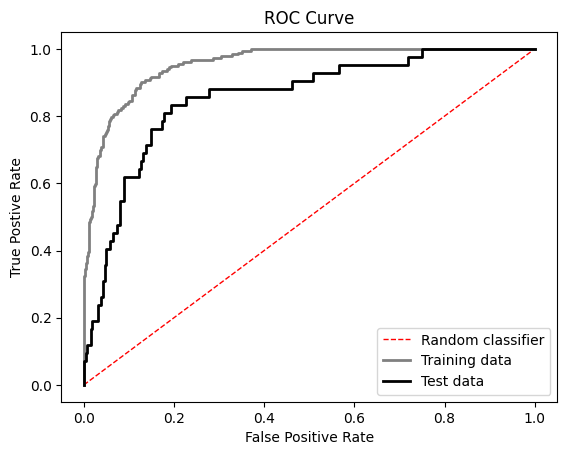

In [15]:
curves =  exp.get_curves()
train = curves[0]
test = curves[1]

plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Random classifier')
plt.plot(train['x'], train['y'], lw = 2, c='grey')
plt.plot(test['x'], test['y'], lw = 2, c='k')

plt.legend(['Random classifier', 'Training data', 'Test data'], loc='lower right')
plt.title('ROC Curve')


plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(figures_path/'roc_curve_REVIEW.svg')

In [37]:
path = Path('/Users/mds8301/Desktop/temp/over_day_5/eval_data/inference_results_4sec.npz')
results = np.load(path)
x_test = results['x_test']
y_test = results['y_test']
y_test_pred = results['y_test_pred']


In [39]:
results["x_train"].shape

(906, 1, 6104)

In [29]:
def make_label_df(y_true, y_pred):

    label_df = (
        pl.DataFrame({'y_true': y_true, "y_pred": y_pred})
        .with_columns(
            pl.Series('trial', np.arange(0, y_true.shape[0])),
            pl.when(pl.col('y_true')==1.0).then(pl.lit('Escape')).otherwise(pl.lit('Avoid')).alias('ground_truth'),
             pl.when(pl.col('y_pred')==1.0).then(pl.lit('Escape')).otherwise(pl.lit('Avoid')).alias('predicted')
        )
        .drop(['y_true', 'y_pred'])
        )
    return label_df
true_labels = make_label_df(y_test, y_test_pred)


In [57]:
x_test_ds = x_test.reshape(-1, x_test.shape[-1])[:, :4*1071][:,::80]

In [58]:
x_test_ds.shape

(302, 54)

In [59]:
time = np.linspace(-1,3, x_test_ds.shape[-1])
traces = (pl.DataFrame(x_test_ds.T)
          .with_columns(pl.Series('time', time))
.melt(id_vars =['time'], variable_name = 'trial')
.with_columns(pl.col('trial').str.replace('column_','').cast(pl.Int64))
)

all_df = traces.join(true_labels, on = 'trial')
all_df
               

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_98244/888638669.py:4: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars =['time'], variable_name = 'trial')


time,trial,value,ground_truth,predicted
f64,i64,f32,str,str
-1.0,0,-1.459656,"""Avoid""","""Avoid"""
-0.924528,0,-1.54354,"""Avoid""","""Avoid"""
-0.849057,0,-1.537645,"""Avoid""","""Avoid"""
-0.773585,0,-1.445995,"""Avoid""","""Avoid"""
-0.698113,0,-1.286569,"""Avoid""","""Avoid"""
…,…,…,…,…
2.698113,301,0.284826,"""Escape""","""Avoid"""
2.773585,301,0.286567,"""Escape""","""Avoid"""
2.849057,301,0.185092,"""Escape""","""Avoid"""


# Visualizing true vs predicted lables
- indisict, but you can see the difference in the escape which I think is good

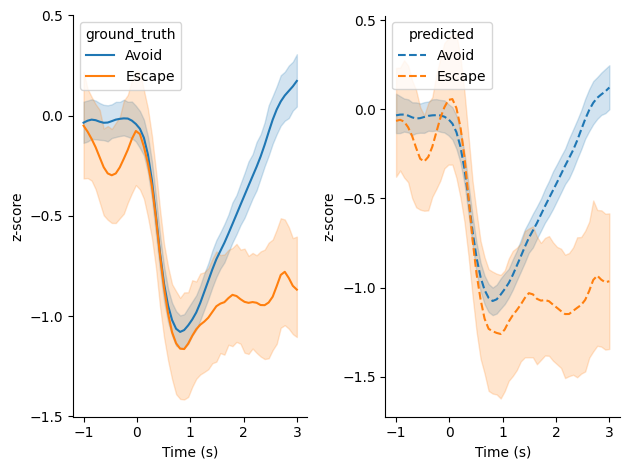

In [61]:
fig, ax = plt.subplot_mosaic(mosaic="""AB""")

format = {
    "yticks": [-1.5, -1, -0.5, 0,  0.5], 
    "ylabel":'z-score',
    'xlabel': 'Time (s)'
}

sns.lineplot(all_df, x='time', y='value', hue='ground_truth', ax=ax['A'])
ax['A'].set(**format)
sns.lineplot(all_df, x='time', y='value', hue='predicted', ax=ax['B'], linestyle ='--')
ax['B'].set(**format)

sns.despine()
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(figures_path / 'true_vs_pred_REVIEW.svg', dpi=300)